In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sc_stats
import json
import random
import seaborn as sns

import spacy

# Text analysis
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SpanishStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('tokenizers/punkt/spanish.pickle')
nltk.download('stopwords')

import unicodedata

from wordcloud import WordCloud, STOPWORDS

import analysis_utils as aute

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\demos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading tokenizers/punkt/spanish.pickle: Package
[nltk_data]     'tokenizers/punkt/spanish.pickle' not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\demos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
rdm_th = 0
corr_th = 0.85

nlp_spanish = spacy.load("es_core_news_sm")

random.seed(rdm_th)

In [3]:
with open('../LableniBotConfig/avoid_words.json', encoding='utf-8') as fh:
    avoid_words_list = json.load(fh)

tokenize_spanish = nltk.data.load('tokenizers/punkt/spanish.pickle')
spanish_stemmer = SpanishStemmer()
spanish_stopwords_th = stopwords.words('spanish')

In [4]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

Only conversations with more than 5 sentences are taken in account.

In [9]:
path_to_conversations = "../Conversations/"

all_df_list = []
for conv in os.listdir(path_to_conversations):
    excel_name = [file for file in os.listdir(path_to_conversations + conv) if ".xlsx" in file][0]
    try:
        df_x = pd.read_excel(path_to_conversations + conv + "/" + excel_name)
        if df_x.shape[0] > 5:
            all_df_list.append(df_x.iloc[1:].reset_index(drop=True))
    except:
        print("Bad file", path_to_conversations + conv + "/" + excel_name)
            
print("Number of conversations:", len(all_df_list))

Bad file ../Conversations/Elena_20221005_112930.120/Conv_20221005_112930.120.xlsx
Number of conversations: 60


In [10]:
def clean_word(word):
    special_characters = ["?", "¿", "!", "¡", ".", ","]
    w_new = word.lower()
    for s_c in special_characters:
        w_new = w_new.replace(s_c, "")
        
    return w_new

def avoid_words_func(text):
    return " ".join([w for w in text.split() if clean_word(w) not in avoid_words_list])

def clean_text(text, subject_name, 
               tokenize_spanish=tokenize_spanish, 
               spanish_stopwords_th=spanish_stopwords_th, 
               spanish_stemmer=spanish_stemmer, 
               use_stemmer=True):
    
    text = text.lower()
    text = text.replace('?', "").replace('¿', "").replace('!', "").replace('¡', "")
    if subject_name:
        text = text.replace(subject_name, "")
    text = strip_accents(text)
    
    text_token_list = []
    if use_stemmer:
        for word in text.split():
            token_text = tokenize_spanish.tokenize(word)
            if len(token_text) > 0 and word not in spanish_stopwords_th:
                text_token_list.append(spanish_stemmer.stem(token_text[0]))
    else:
        text_token_list.append(text)
            
    text = " ".join(text_token_list)
    
    return text

In [11]:
save_res_list = []
for i_df_x, df_x in enumerate(all_df_list):
    
    subject_name = df_x["SubjectId"].iloc[0]
    
    # ###############
    # ### General ###
    # ###############
    num_conv = df_x.shape[0] // 2
    
    text = ". ".join(df_x["SpanishMessage"].values)
    whole_text = clean_text(text, subject_name)
    
    num_words = len(whole_text.split(" "))
    conv_time_s = df_x["UnixTimestampInit"].values[-1] - df_x["UnixTimestampEnd"].values[0]
    # freq_conv_s = np.mean(df_x["unixtimestamp"].values[1:] - df_x["unixtimestamp"].values[:-1])
    
    # The first raw is removed because the first answer is instantaneous
    time_answer_list, time_bot_answer_list, time_pers_answer_list = [], [], []
    for i in range(df_x.shape[0]-1):
        delta_t = df_x["UnixTimestampInit"].iloc[i+1] - df_x["UnixTimestampEnd"].iloc[i]
        if df_x["Source"].iloc[i] == "Person":
            time_bot_answer_list.append(delta_t)
        else:
            time_pers_answer_list.append(delta_t)

        delta_t = df_x["UnixTimestampInit"].iloc[i+1] - df_x["UnixTimestampEnd"].iloc[i]
        time_answer_list.append(delta_t)
    
    # ###########
    # ### Bot ###
    # ###########
    df_bot = df_x[df_x["Source"] == "Bot"]
    
    text = ". ".join(df_bot["SpanishMessage"].values)
    bot_text = clean_text(text, subject_name)

    num_words_bot = len(bot_text.split(" "))
    
    # ##############
    # ### Person ###
    # ##############
    df_person = df_x[df_x["Source"] == "Person"]
    
    text = ". ".join(df_person["SpanishMessage"].values)
    person_text = clean_text(text, subject_name)
    
    num_words_person = len(person_text.split(" "))
    
    save_res_list.append({
        # General
        "SubjectId": df_x["SubjectId"].iloc[0],
        "FirstDate": df_x["UnixTimestampInit"].iloc[0],
        "LastDate": df_x["UnixTimestampEnd"].iloc[-1],
        "ConvTime_s": conv_time_s,
        # "FreqTime_s": freq_conv_s,
        "NumConv": num_conv,
        "NumSamples": df_x.shape[0],
        "AllText": avoid_words_func(whole_text),
        "AllNumUniqWords": len(set([w for w in whole_text.split() if w.isalpha()])),
        "AllOriginalText": avoid_words_func( ". ".join(df_x["SpanishMessage"].values) ),
        "AllNumWords": num_words,
        "AllTimeAns": np.mean(time_answer_list),
        # ### Bot ###
        "BotText": avoid_words_func(bot_text),
        "BotNumUniqWords": len(set([w for w in bot_text.split() if w.isalpha()])),
        "BotOriginalText": avoid_words_func( ". ".join(df_bot["SpanishMessage"].values) ),
        "BotNumWords": num_words_bot,
        "BotTimeAns": np.mean(time_bot_answer_list),
        # ### Person ###
        "PersonText": avoid_words_func(person_text),
        "PersonNumUniqWords": len(set([w for w in person_text.split() if w.isalpha()])),
        "PersonOriginalText": avoid_words_func( ". ".join(df_person["SpanishMessage"].values) ),
        "PersonNumWords": num_words_person,
        "PersonTimeAns": np.mean(time_pers_answer_list),
    })
    
df_save = pd.DataFrame(save_res_list)
df_save.head(5)

,SubjectId,FirstDate,LastDate,ConvTime_s,NumConv,NumSamples,AllText,AllNumUniqWords,AllOriginalText,AllNumWords,...,BotText,BotNumUniqWords,BotOriginalText,BotNumWords,BotTimeAns,PersonText,PersonNumUniqWords,PersonOriginalText,PersonNumWords,PersonTimeAns
0,Aiatana,1.663575e+09,1.663575e+09,239.592244,11,22,"hol gema, aitana. hol aitana, tal. bien, encan...",59,"hola gema, yo Aitana. Hola Aitana, ¿qué tal?. ...",167,...,"hol aitana, tal. bien, gracias. gust conoc nue...",40,"Hola Aitana, ¿qué tal?. Bien, gracias. Me gust...",95,0.022120,"hol gema, aitana. bien, encant conocerte, tu. ...",32,"hola gema, yo Aitana. Muy bien, encantado de c...",72,9.330440
1,Aiatan,1.663577e+09,1.663577e+09,226.315542,10,20,"hol isabel llam aitan encantada.. hola, aitana...",52,Hola Isabel yo me llamo Aitana encantada.. Hol...,130,...,"hola, aitana. encantada. eres. ah, san sebasti...",39,"Hola, Aitana. Encantada. ¿De dónde eres?. Ah, ...",85,0.021642,hol isabel llam aitan encantada.. valenci tu. ...,24,Hola Isabel yo me llamo Aitana encantada.. yo ...,45,11.222158
2,Aitana,1.663575e+09,1.663575e+09,243.337212,14,28,"llam aitana. encantada, aitana. eres. valenci ...",58,"yo me llamo Aitana. Encantada, Aitana. ¿De dón...",141,...,"encantada, aitana. eres. vigo. gust hac tiemp ...",34,"Encantada, Aitana. ¿De dónde eres?. De Vigo. ¿...",83,0.022084,"llam aitana. valenci tu. bueno, pues gust leer...",30,"yo me llamo Aitana. de Valencia y tú. Bueno, p...",58,7.171459
3,Aitana,1.663576e+09,1.663576e+09,18.777188,2,5,"hola, aitan encantada.. gusto, aitana.. tal es...",12,"Hola, yo Aitana encantada.. Mucho gusto, Aitan...",22,...,"gusto, aitana.. plan futur",2,"Mucho gusto, Aitana.. ¿ Que planes tienes para...",4,0.017453,"hola, aitan encantada.. tal estas. pues buen p...",10,"Hola, yo Aitana encantada.. Qué tal? Cómo está...",17,4.313773
4,Aitana,1.663576e+09,1.663576e+09,145.789522,7,14,"hol alejandr aitan encantada.. hol aitana, gus...",31,Hola Alejandra yo Aitana encantada.. Hola Aita...,96,...,"hol aitana, gusto.aitana: alejandra, encant co...",21,"Hola Aitana, mucho gusto.Aitana: Alejandra, me...",60,0.020404,hol alejandr aitan encantada.. valenci tambi g...,19,Hola Alejandra yo Aitana encantada.. Yo soy de...,35,11.150576


In [12]:
# Clean DF

df_save = df_save[df_save["PersonTimeAns"] <= 10]
df_save = df_save.reset_index(drop=True)

In [13]:
print("Shape", df_save.shape)
print("Columns", df_save.columns)

Shape (46, 21)
Columns Index(['SubjectId', 'FirstDate', 'LastDate', 'ConvTime_s', 'NumConv',
       'NumSamples', 'AllText', 'AllNumUniqWords', 'AllOriginalText',
       'AllNumWords', 'AllTimeAns', 'BotText', 'BotNumUniqWords',
       'BotOriginalText', 'BotNumWords', 'BotTimeAns', 'PersonText',
       'PersonNumUniqWords', 'PersonOriginalText', 'PersonNumWords',
       'PersonTimeAns'],
      dtype='object')


## EDA

In [14]:
aute.stat_print(df_save["ConvTime_s"]/60, "Conversation time (min)", 2)
aute.stat_print(df_save["NumSamples"], "Number Sentences ", 2)

Mean Conversation time (min) = 2.18 +/- 1.18 ; Median = 2.11 ; Min. =  0.27 ; Max. =  5.53
Mean Number Sentences  = 15.28 +/- 6.3 ; Median = 14.0 ; Min. =  5 ; Max. =  32


### Some plots

The following plots study the correlation of the number of words against the number of sentences and the time of the conversation. 

Correlation value 0.8053080579356793
P-value ***
Coefficients: 
 [11.97455231] 
Intercept: 
 -0.8944392082940738
R-square: 0.65


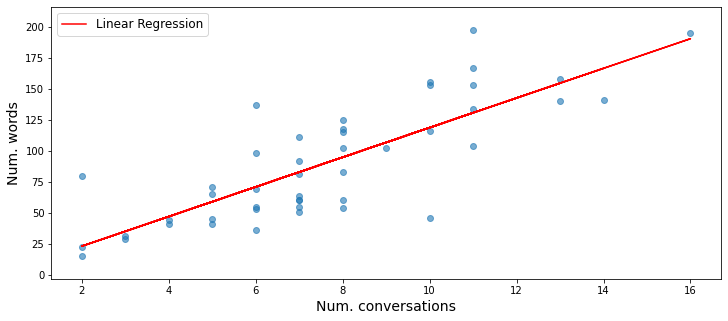

Correlation value 0.907623875182561
P-value ***
Coefficients: 
 [0.60577302] 
Intercept: 
 10.330724595367386
R-square: 0.82


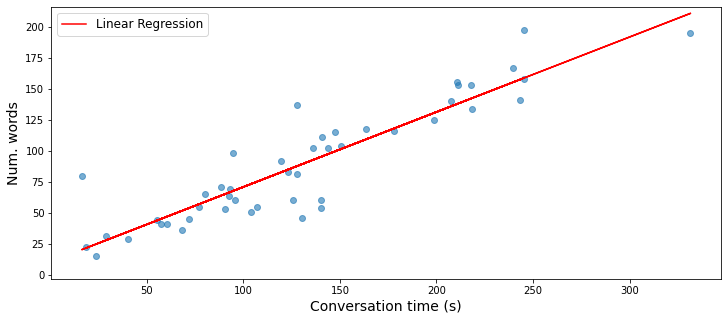

In [15]:
aute.make_scatter_plot(df=df_save, 
                       x_feat="NumConv", x_name="Num. conversations", 
                       y_feat="AllNumWords", y_name="Num. words", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="ConvTime_s", x_name="Conversation time (s)", 
                       y_feat="AllNumWords", y_name="Num. words", 
                       lr_mode=True)

Mean All number of words = 89.6957 +/- 47.0882 ; Median = 80.5 ; Min. =  15 ; Max. =  198
Mean Person number of words = 38.8913 +/- 24.1348 ; Median = 33.0 ; Min. =  4 ; Max. =  88
Mean Bot number of words = 50.7391 +/- 28.1683 ; Median = 46.0 ; Min. =  4 ; Max. =  124
P-value 0.034842832268695015 string p value *


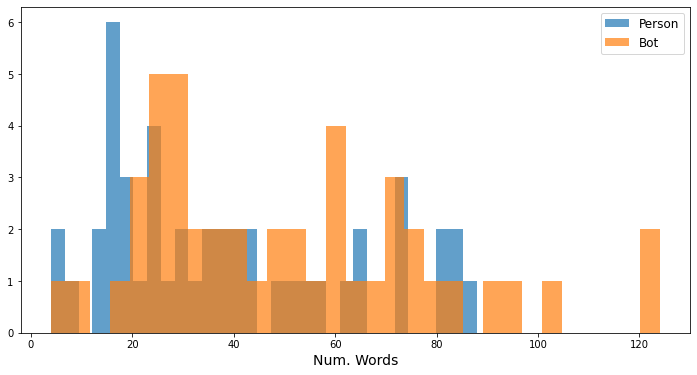

Mean Mean answer time (s) = 3.48 +/- 0.73 ; Median = 3.61 ; Min. =  1.7 ; Max. =  4.72
Mean Mean person answer time (s) = 7.45 +/- 1.51 ; Median = 7.58 ; Min. =  3.38 ; Max. =  9.89
Mean Mean bot answer time (s) = 0.02 +/- 0.0 ; Median = 0.02 ; Min. =  0.02 ; Max. =  0.02
P-value 4.006723002760187e-52 string p value ***


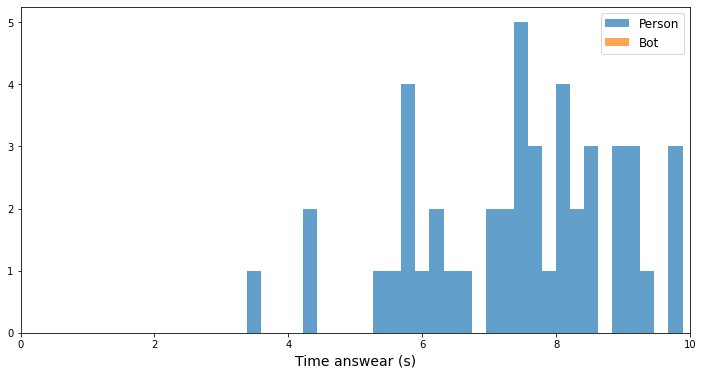

Mean All unique number of words = 37.913 +/- 19.1218 ; Median = 34.5 ; Min. =  7 ; Max. =  70
Mean Person unique words = 19.9565 +/- 12.4638 ; Median = 16.0 ; Min. =  3 ; Max. =  50
Mean Bot unique words = 23.2826 +/- 13.1259 ; Median = 23.0 ; Min. =  2 ; Max. =  51
P-value 0.22091188099635398 string p value -


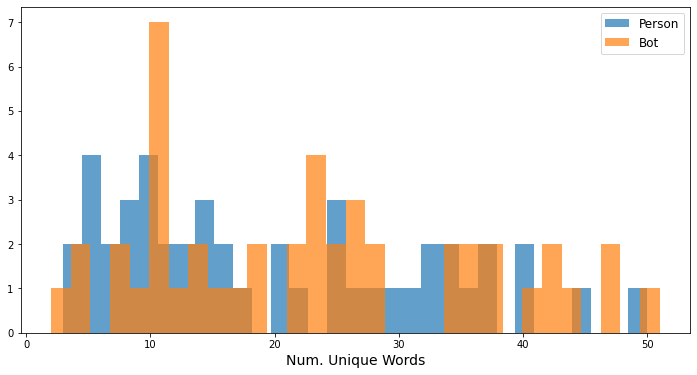

In [16]:
# #######################
# ### Number of words ###
# #######################

aute.stat_print(df_save["AllNumWords"].values, "All number of words")
aute.stat_print(df_save["PersonNumWords"].values, "Person number of words")
aute.stat_print(df_save["BotNumWords"].values, "Bot number of words")
_, p = sc_stats.f_oneway(df_save["PersonNumWords"].values, df_save["BotNumWords"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["PersonNumWords"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["BotNumWords"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Num. Words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

# ###################
# ### Time answer ###
# ###################

aute.stat_print(df_save["AllTimeAns"].values, "Mean answer time (s)", 2)
aute.stat_print(df_save["PersonTimeAns"].values, "Mean person answer time (s)", 2)
aute.stat_print(df_save["BotTimeAns"].values, "Mean bot answer time (s)", 2)
_, p = sc_stats.f_oneway(df_save["PersonTimeAns"].values, df_save["BotTimeAns"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["PersonTimeAns"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["BotTimeAns"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Time answear (s)", fontsize=14)
plt.legend(fontsize=12)

plt.xlim(0, 10)

plt.show()

# ####################
# ### Unique words ###
# ####################

aute.stat_print(df_save["AllNumUniqWords"].values, "All unique number of words")
aute.stat_print(df_save["PersonNumUniqWords"].values, "Person unique words")
aute.stat_print(df_save["BotNumUniqWords"].values, "Bot unique words")
_, p = sc_stats.f_oneway(df_save["PersonNumUniqWords"].values, df_save["BotNumUniqWords"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["PersonNumUniqWords"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["BotNumUniqWords"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Num. Unique Words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

### Crude Text 

#### Token size analysis

In [17]:
def obtain_word_analysis(data, target):
    result_list = []
    for text in data[target].tolist():
        
        original_text_clean = clean_text(text, subject_name=None, use_stemmer=False)
        sentence_list = [sentence for sentence in original_text_clean.split(".") if len(sentence) > 1]
        len_list = [len(sent.split()) for sent in sentence_list]
        
        result_list.append({
            "mean": np.mean(len_list),
            "median": np.median(len_list),
            "std": np.std(len_list),
            "num_words_in_sentence": len_list
        })

    return pd.DataFrame(result_list)

Mean Number of words for BOT by sentence = 7.2845 +/- 5.2119 ; Median = 6.0 ; Min. =  1 ; Max. =  31
Mean Number of words for Person by sentence = 9.3261 +/- 7.1332 ; Median = 7.0 ; Min. =  1 ; Max. =  41
P-value 4.297979508998303e-07 string p value ***


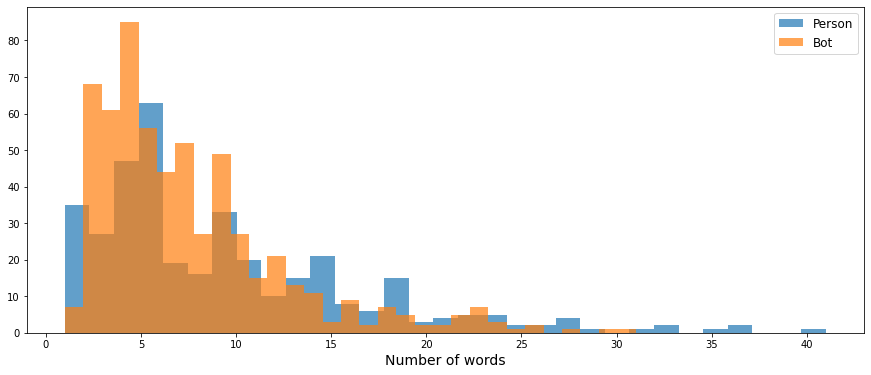

In [18]:
df_bot_result = obtain_word_analysis(df_save, "BotOriginalText")
df_person_result = obtain_word_analysis(df_save, "PersonOriginalText")

bot_word_number = []
for my_list in df_bot_result["num_words_in_sentence"].tolist():
    bot_word_number += my_list

person_word_number = []
for my_list in df_person_result["num_words_in_sentence"].tolist():
    person_word_number += my_list

aute.stat_print(bot_word_number, "Number of words for BOT by sentence")
aute.stat_print(person_word_number, "Number of words for Person by sentence")

_, p = sc_stats.f_oneway(person_word_number, bot_word_number)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(15, 6))

plt.hist(person_word_number, bins=31, alpha=0.7, label="Person")
plt.hist(bot_word_number, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Number of words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

Mean Number of words for ALL by sentence = 8.0881 +/- 6.1125 ; Median = 6.0 ; Min. =  1 ; Max. =  41


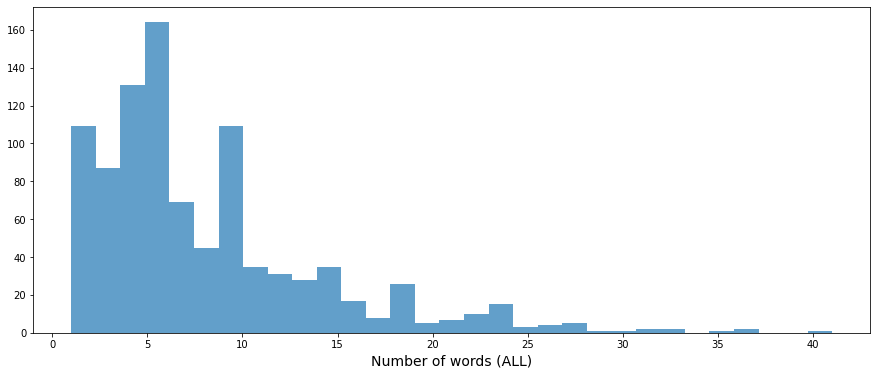

In [19]:
df_all_result = obtain_word_analysis(df_save, "AllOriginalText")

all_word_number = []
for my_list in df_all_result["num_words_in_sentence"].tolist():
    all_word_number += my_list

aute.stat_print(all_word_number, "Number of words for ALL by sentence")

plt.figure(figsize=(15, 6))

plt.hist(all_word_number, bins=31, alpha=0.7, label="All")
plt.xlabel("Number of words (ALL)", fontsize=14)

plt.show()

## WordCloud analysis

- Falta tokenizar las palabras, eliminar acentos y etc.

- Estaria bien establecer un protocolo para eliminar el nombre del sujeto.

- Estudiar el número y cuales son las stopwords localizadas en el Bot y en la persona. Ver si estas stopwords son las mismas para ambos o distintas, etc. Posiblemente el sujeto utilice más stopwords que el sujeto o quizá no. 

### Whole text

In [20]:
whole_text = " ".join(df_save["AllOriginalText"]).replace(".", " ").replace(",", " ").lower()

all_words_list = [word for word in whole_text.split() if word not in spanish_stopwords_th]
uniq_words_list = list(set(all_words_list))
freq_words_appear = [
    {"Word": word, "Times": np.sum(np.array(all_words_list)==word)} for word in uniq_words_list
]
df_freq_all_words = pd.DataFrame(freq_words_appear).sort_values("Times", ascending=False).reset_index(drop=True)
df_freq_all_words.head(15)

,Word,Times
0,bien,84
1,gusta,82
2,pues,73
3,¿qué,58
4,hola,52
5,si,49
6,gustaría,42
7,hacer,39
8,gracias,37
9,tiempo,31


In [21]:
print("Number of different words", df_freq_all_words.shape[0])
print("Mean frequency", np.round(np.mean(df_freq_all_words["Times"]), 5), 
      "+/-", np.round(np.std(df_freq_all_words["Times"]), 5), 
      "Max", np.max(df_freq_all_words["Times"]), 
      "Min", np.min(df_freq_all_words["Times"]) )

Number of different words 1164
Mean frequency 3.43729 +/- 6.51039 Max 84 Min 1


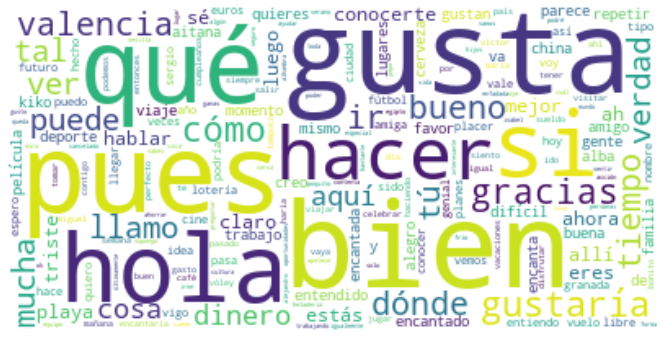

In [22]:
plt.figure(figsize=(15, 6))

all_wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(all_words_list))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Bot analysis

In [23]:
whole_bot_text = " ".join(df_save["BotOriginalText"]).replace(".", " ").replace(",", " ").lower()

all_bot_words_list = [word for word in whole_bot_text.split() if word not in spanish_stopwords_th]
uniq_bot_words_list = list(set(all_bot_words_list))
freq_bot_words_appear = [
    {"Word": word, "Times": np.sum(np.array(all_bot_words_list)==word)} for word in uniq_bot_words_list
]
df_freq_bot_words = pd.DataFrame(freq_bot_words_appear).sort_values("Times", ascending=False).reset_index(drop=True)
df_freq_bot_words.head(15)

,Word,Times
0,¿qué,58
1,gusta,49
2,bien,36
3,gracias,30
4,gustaría,28
5,tiempo,22
6,ah,20
7,si,19
8,hacer,19
9,hola,17


In [24]:
print("Number of different words", df_freq_bot_words.shape[0])
print("Mean frequency", np.round(np.mean(df_freq_bot_words["Times"]), 5), 
      "+/-", np.round(np.std(df_freq_bot_words["Times"]), 5), 
      "Max", np.max(df_freq_bot_words["Times"]), 
      "Min", np.min(df_freq_bot_words["Times"]) )

Number of different words 792
Mean frequency 2.95707 +/- 4.39762 Max 58 Min 1


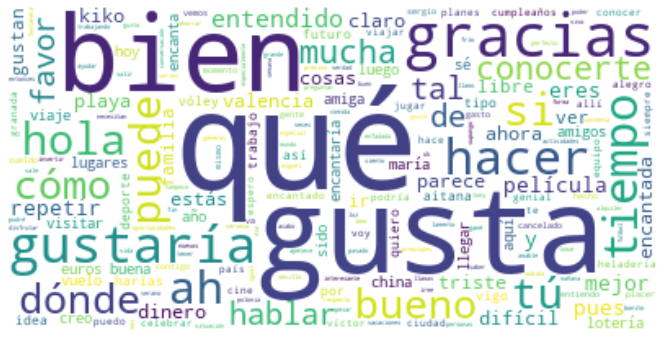

In [25]:
plt.figure(figsize=(15, 6))

all_wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(all_bot_words_list))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Analysis against Questionare

In [26]:
random_target = [np.random.randint(1, 5+1) for _ in range(df_save.shape[0])]
random_binary_target = [np.random.randint(0, 1+1) for _ in range(df_save.shape[0])]

In [27]:
df_save["MultilabelTarget"] = random_target
df_save["BinaryTarget"] = random_binary_target

In [28]:
aute.stat_print(df_save["MultilabelTarget"], "Realism degree score", precision=2)
aute.stat_print(100 * df_save["BinaryTarget"], "Repetition score", precision=2)

Mean Realism degree score = 2.63 +/- 1.42 ; Median = 2.0 ; Min. =  1 ; Max. =  5
Mean Repetition score = 54.35 +/- 49.81 ; Median = 100.0 ; Min. =  0 ; Max. =  100


In [29]:
print("Columns", df_save.columns)
df_save.head(5)

Columns Index(['SubjectId', 'FirstDate', 'LastDate', 'ConvTime_s', 'NumConv',
       'NumSamples', 'AllText', 'AllNumUniqWords', 'AllOriginalText',
       'AllNumWords', 'AllTimeAns', 'BotText', 'BotNumUniqWords',
       'BotOriginalText', 'BotNumWords', 'BotTimeAns', 'PersonText',
       'PersonNumUniqWords', 'PersonOriginalText', 'PersonNumWords',
       'PersonTimeAns', 'MultilabelTarget', 'BinaryTarget'],
      dtype='object')


,SubjectId,FirstDate,LastDate,ConvTime_s,NumConv,NumSamples,AllText,AllNumUniqWords,AllOriginalText,AllNumWords,...,BotOriginalText,BotNumWords,BotTimeAns,PersonText,PersonNumUniqWords,PersonOriginalText,PersonNumWords,PersonTimeAns,MultilabelTarget,BinaryTarget
0,Aiatana,1.663575e+09,1.663575e+09,239.592244,11,22,"hol gema, aitana. hol aitana, tal. bien, encan...",59,"hola gema, yo Aitana. Hola Aitana, ¿qué tal?. ...",167,...,"Hola Aitana, ¿qué tal?. Bien, gracias. Me gust...",95,0.022120,"hol gema, aitana. bien, encant conocerte, tu. ...",32,"hola gema, yo Aitana. Muy bien, encantado de c...",72,9.330440,5,1
1,Aitana,1.663575e+09,1.663575e+09,243.337212,14,28,"llam aitana. encantada, aitana. eres. valenci ...",58,"yo me llamo Aitana. Encantada, Aitana. ¿De dón...",141,...,"Encantada, Aitana. ¿De dónde eres?. De Vigo. ¿...",83,0.022084,"llam aitana. valenci tu. bueno, pues gust leer...",30,"yo me llamo Aitana. de Valencia y tú. Bueno, p...",58,7.171459,3,0
2,Aitana,1.663576e+09,1.663576e+09,18.777188,2,5,"hola, aitan encantada.. gusto, aitana.. tal es...",12,"Hola, yo Aitana encantada.. Mucho gusto, Aitan...",22,...,"Mucho gusto, Aitana.. ¿ Que planes tienes para...",4,0.017453,"hola, aitan encantada.. tal estas. pues buen p...",10,"Hola, yo Aitana encantada.. Qué tal? Cómo está...",17,4.313773,2,0
3,Aitana,1.663576e+09,1.663577e+09,245.110362,11,22,"hol mari aitana. hol aitana, tal. bien, tal. b...",65,"hola yo soy Aitana. Hola Aitana, ¿Qué tal?. Mu...",198,...,"Hola Aitana, ¿Qué tal?. Estoy muy bien, hoy ga...",124,0.020891,"hol mari aitana. bien, tal. madr mia, pues. bu...",37,"hola yo soy Aitana. Muy bien, y tú qué tal?. m...",74,9.885516,5,1
4,Aitana,1.663577e+09,1.663577e+09,127.594636,7,14,"hol alba aitana. hol aitana. estas. bien, verd...",35,hola Alba yo Aitana. Hola Aitana. ¿Cómo estás?...,81,...,Hola Aitana. ¿Cómo estás?. Estoy un poco trist...,49,0.018556,"hol alba aitana. bien, verd ser lun contenta. ...",15,"hola Alba yo Aitana. Muy bien, la verdad que p...",32,8.540635,3,1


Correlation value 0.17916959806013585
P-value -
Coefficients: 
 [176.19829297] 
Intercept: 
 -0.8844475040175079
R-square: 0.03


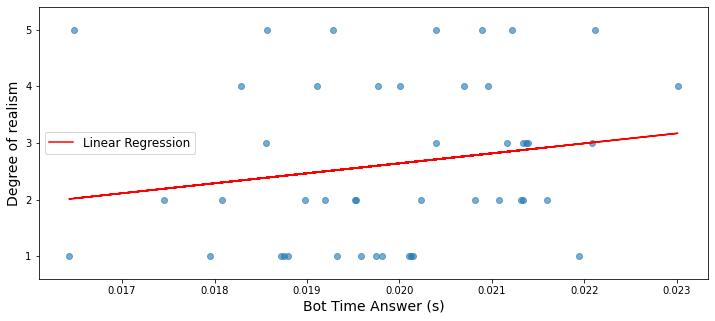

Correlation value 0.34245482586239256
P-value *
Coefficients: 
 [0.0772239] 
Intercept: 
 1.4502521669667228
R-square: 0.12


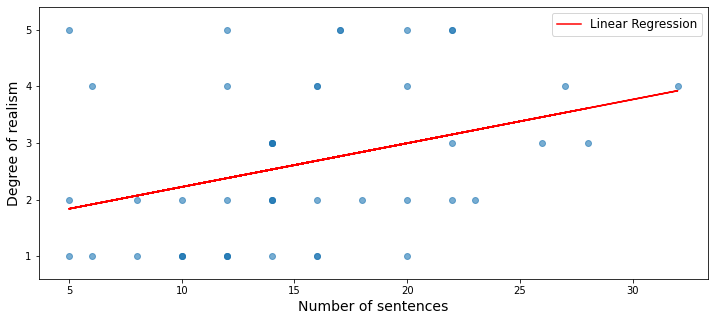

Correlation value 0.45706722352643114
P-value **
Coefficients: 
 [0.049437] 
Intercept: 
 1.4794124504546515
R-square: 0.21


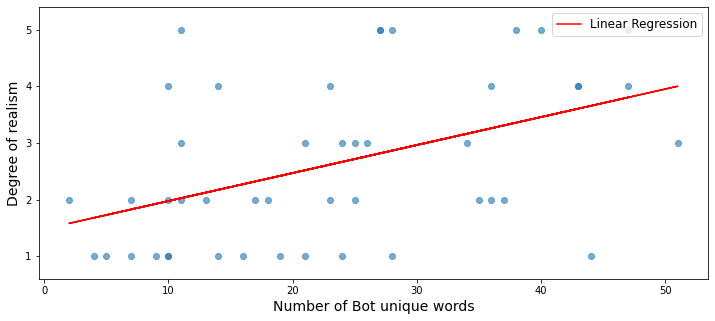

Correlation value 0.5118351387152332
P-value ***
Coefficients: 
 [0.02579711] 
Intercept: 
 1.3215120420644362
R-square: 0.26


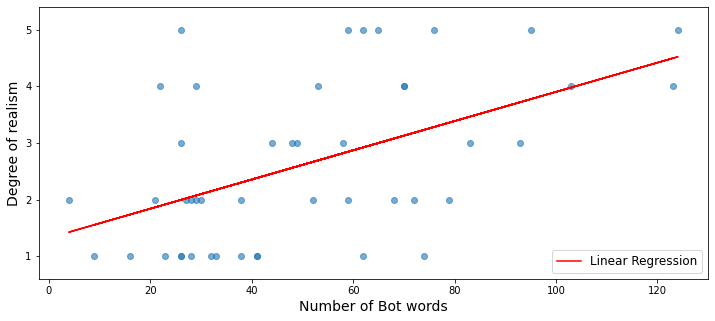

In [30]:
aute.make_scatter_plot(df=df_save, 
                       x_feat="BotTimeAns", x_name="Bot Time Answer (s)", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="NumSamples", x_name="Number of sentences", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="BotNumUniqWords", x_name="Number of Bot unique words", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="BotNumWords", x_name="Number of Bot words", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

P-value 0.8869714239442444 with significance -


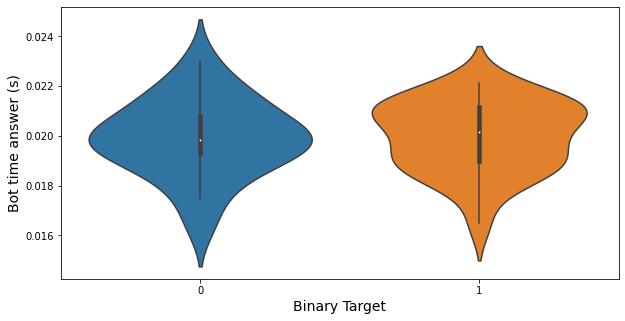

P-value 0.7510489711831946 with significance -


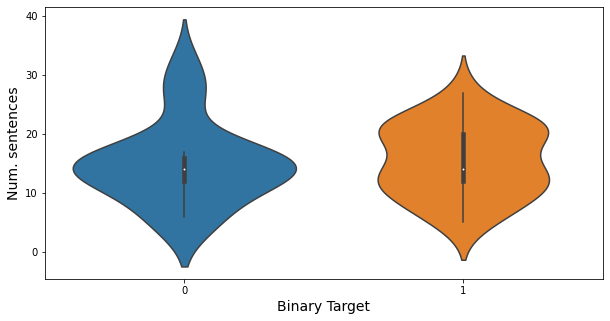

P-value 0.03883584631835019 with significance *


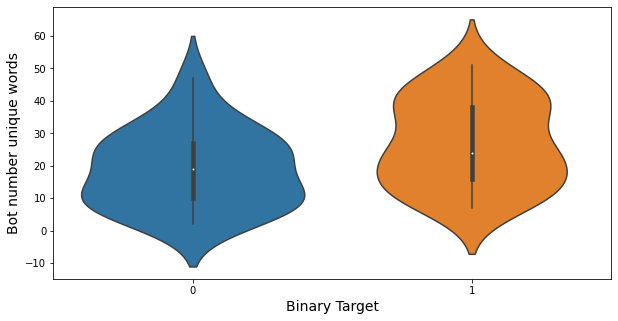

P-value 0.09991128812540781 with significance -


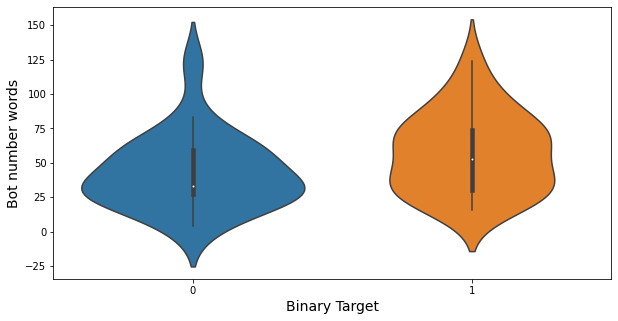

In [31]:
aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotTimeAns", y_name="Bot time answer (s)", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="NumSamples", y_name="Num. sentences", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotNumUniqWords", y_name="Bot number unique words", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotNumWords", y_name="Bot number words", 
                      violin_plot=True)

## Study sentence similarity

In [32]:
# ### Bot ###

all_bot_sentence_list = []
for sent in df_save["BotOriginalText"].tolist():
    all_bot_sentence_list += sent.split(". ")

save_vector_list = []
for sent in all_bot_sentence_list:
    doc_sent_nlp = nlp_spanish(sent)
    if doc_sent_nlp.vector.shape[0] > 0:
        save_vector_list.append( doc_sent_nlp.vector/doc_sent_nlp.vector_norm )
    
save_res_similarity_bot_list = []
for i, i_sent in enumerate(save_vector_list[:-1]):
    for j_sent in save_vector_list[(i+1):]:
        save_res_similarity_bot_list.append(
            aute.cosine_similarity(i_sent, j_sent)
        )
        
# ### Person ###
        
all_person_sentence_list = []
for sent in df_save["PersonOriginalText"].tolist():
    all_person_sentence_list += sent.split(". ")

save_vector_list = []
for sent in all_person_sentence_list:
    doc_sent_nlp = nlp_spanish(sent)
    if doc_sent_nlp.vector.shape[0] > 0:
        save_vector_list.append( doc_sent_nlp.vector/doc_sent_nlp.vector_norm )
    
save_res_similarity_person_list = []
for i, i_sent in enumerate(save_vector_list[:-1]):
    for j_sent in save_vector_list[(i+1):]:
        save_res_similarity_person_list.append(
            aute.cosine_similarity(i_sent, j_sent)
        )

Mean Bot sentence similarity = 0.2224 +/- 0.1816 ; Median = 0.214 ; Min. =  -0.3959 ; Max. =  1.0
Mean Person sentence similarity = 0.2531 +/- 0.1793 ; Median = 0.2539 ; Min. =  -0.3656 ; Max. =  1.0


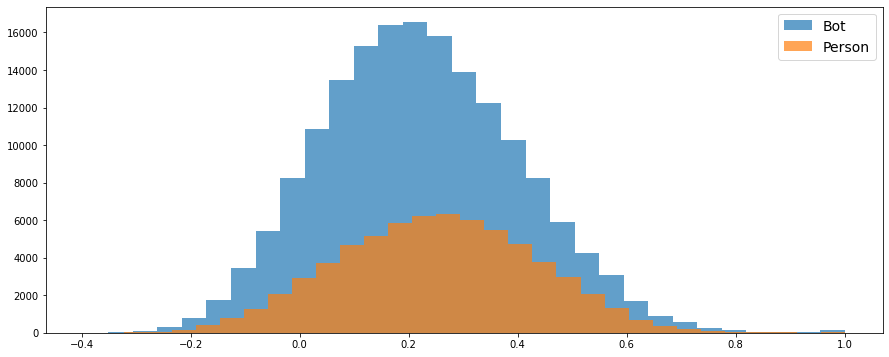

In [33]:
aute.stat_print(save_res_similarity_bot_list, "Bot sentence similarity")
aute.stat_print(save_res_similarity_person_list, "Person sentence similarity")

plt.figure(figsize=(15, 6))

plt.hist(save_res_similarity_bot_list, bins=31, alpha=0.7, label="Bot")
plt.hist(save_res_similarity_person_list, bins=31, alpha=0.7, label="Person")

plt.legend(fontsize=14)

plt.show()

### Circle plot

In [34]:
all_subj_states_1 = np.array([np.random.randint(0, 2, size=2) for i in range(50)])
mean_states_1 = np.mean(all_subj_states_1, axis=0)
std_states_1 = np.std(all_subj_states_1, axis=0)

all_subj_states_2 = np.array([np.random.randint(-1, 1, size=2) for i in range(50)])
mean_states_2 = np.mean(all_subj_states_2, axis=0)
std_states_2 = np.std(all_subj_states_2, axis=0)

all_subj_states_3 = np.array([np.random.randint(-1, 2, size=2) for i in range(50)])
mean_states_3 = np.mean(all_subj_states_3, axis=0)
std_states_3 = np.std(all_subj_states_3, axis=0)

all_subj_states_4 = np.array([np.random.randint(-2, 2, size=2) for i in range(50)])
mean_states_4 = np.mean(all_subj_states_4, axis=0)
std_states_4 = np.std(all_subj_states_4, axis=0)

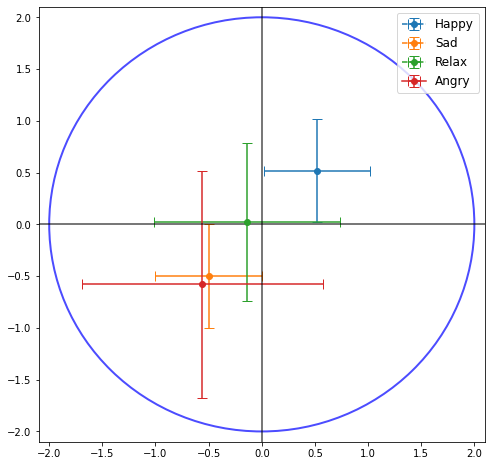

In [35]:
circle2 = plt.Circle((0, 0), 2, color='blue', fill=False, linewidth=2, alpha=0.7)

fig, ax = plt.subplots(figsize=(8, 8)) # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

plt.errorbar(mean_states_1[0], mean_states_1[1], 
             xerr=std_states_1[0], yerr=std_states_1[1], 
             marker='o', capsize=5, linestyle="--", label="Happy")

plt.errorbar(mean_states_2[0], mean_states_2[1], 
             xerr=std_states_2[0], yerr=std_states_2[1], 
             marker='o', capsize=5, linestyle="--", label="Sad")

plt.errorbar(mean_states_3[0], mean_states_3[1], 
             xerr=std_states_3[0], yerr=std_states_3[1], 
             marker='o', capsize=5, linestyle="--", label="Relax")

plt.errorbar(mean_states_4[0], mean_states_4[1], 
             xerr=std_states_4[0], yerr=std_states_4[1], 
             marker='o', capsize=5, label="Angry")

ax.add_patch(circle2)

plt.axvline(0, c="black", alpha=0.7)
plt.axhline(0, c="black", alpha=0.7)

plt.legend(fontsize=12)

plt.xlim(-2.1, 2.1)
plt.ylim(-2.1, 2.1)

plt.show()

### Classifier

- Hacer un clasificador que sepa o pueda descubrir por las métricas obtenidas de la conversación si es un Bot o una persona. Lo interesante sería que NO.